In [36]:
from __future__ import print_function
import torch, os
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from catboost import *
import plotly.express as px
import plotly
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
%matplotlib inline
from catalyst.dl.runner.supervised import SupervisedRunner as Runner

In [3]:
def transform_data(arr, seq_len = 10):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[ i + seq_len ]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, 1)
    x_var = torch.Tensor(x).float()
    y_var = torch.Tensor(y).float()
    y_var = y_var.view(-1, 1)
    return x_var, y_var

def ruuning_mean(arr, beta  = 0.9):
    for i in range(1, len(arr)):
        arr[i] = beta*arr[i] + (1-beta)*arr[i-1]
    return arr

In [4]:
data = pd.read_csv('T1.csv')
data.head(3)

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789


In [15]:
train_size = int(0.9*len(data))
valid_size = int(0.1*len(data))
train = data.iloc[:train_size, :]
valid = data.iloc[train_size:, :]

In [23]:
x_train_speed, y_train_speed = transform_data(train['Wind Speed (m/s)'].tolist(), seq_len = 20)
x_valid_speed, y_valid_speed = transform_data(valid['Wind Speed (m/s)'].tolist(), seq_len = 20)

In [24]:
print(f'x_train: {x_train_speed.shape}')
print(f'y_train: {y_train_speed.shape}')
print(f'x_valid: {x_valid_speed.shape}')
print(f'y_valid: {y_valid_speed.shape}')

x_train: torch.Size([45457, 20])
y_train: torch.Size([45457, 1])
x_valid: torch.Size([5033, 20])
y_valid: torch.Size([5033, 1])


In [25]:
x_train_dir, y_train_dir = transform_data(train['Wind Direction (°)'].tolist(), seq_len = 20)
x_valid_dir, y_valid_dir = transform_data(valid['Wind Direction (°)'].tolist(), seq_len = 20)

In [26]:
print('Direction:')
print(f'x_train: {x_train_dir.shape}')
print(f'y_train: {y_train_dir.shape}')
print(f'x_valid: {x_valid_dir.shape}')
print(f'y_valid: {y_valid_dir.shape}')

Direction:
x_train: torch.Size([45457, 20])
y_train: torch.Size([45457, 1])
x_valid: torch.Size([5033, 20])
y_valid: torch.Size([5033, 1])


In [27]:
x_train_dir = (x_train_dir/360).unsqueeze(-1)
x_valid_dir = (x_valid_dir/360).unsqueeze(-1)
y_train_dir = y_train_dir/360
y_valid_dir = y_valid_dir/360

In [28]:
x_train_speed = (x_train_speed/25).unsqueeze(-1)
x_valid_speed = (x_valid_speed/25).unsqueeze(-1)
y_valid_speed = y_valid_speed/25
y_train_speed = y_train_speed/25

In [29]:
x_train = torch.stack([x_train_speed, x_train_dir], dim = 2).squeeze()
x_valid = torch.stack([x_valid_speed, x_valid_dir], dim = 2).squeeze()
y_train = torch.stack([y_train_speed, y_train_dir], dim = 1).squeeze()
y_valid = torch.stack([y_valid_speed, y_valid_dir], dim = 1).squeeze()

In [30]:
y_train.shape

torch.Size([45457, 2])

In [31]:
class LSTM(nn.Module):
    def __init__(self, input_dim = 2, hidden_dim = 100, num_layers = 2, output_dim = 2 , device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers
        self.device = device
        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(self.device).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(self.device).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    

In [76]:
state_dict = torch.load('/storage/WindHack/pytorch-logs/checkpoints/best_full.pth')
model_dict = state_dict['model_state_dict']

In [77]:
model = LSTM(input_dim = 2, hidden_dim = 100, num_layers = 2, output_dim = 2 )
model.load_state_dict(model_dict)
model = model.cuda()
loss_fn = nn.MSELoss()
train_data = TensorDataset(x_train, y_train)
valid_data = TensorDataset(x_valid, y_valid)
loaders = {   'train': DataLoader(train_data, shuffle = True, batch_size = 5000, num_workers = 4),
              'valid' : DataLoader(valid_data, shuffle = False, batch_size = 5000, num_workers = 4)}
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 10, factor = 0.5)

In [78]:
# runner = Runner()
# runner.train(model =  model.cuda(), 
#              criterion = loss_fn, 
#              optimizer = optimizer, 
#              loaders = loaders, 
#              scheduler = scheduler, 
#              logdir = 'pytorch-logs', 
#              num_epochs= 5000, 
#              verbose = True, 
#              load_best_on_end =True
#             )

In [28]:
!pip -q install tensorboard
!tensorboard --logdir='pytorch-logs'


TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.2.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [116]:
out = model(x_valid[100:500, :, :].cuda())

out.shape

torch.Size([400, 2])

In [117]:
y_slice = y_valid[100:500, :]
y_slice.shape

torch.Size([400, 2])

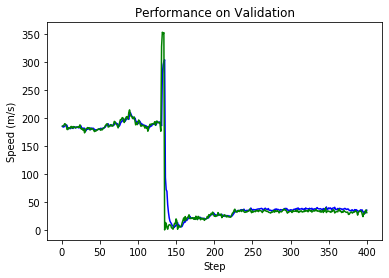

In [118]:
plt.plot(np.arange(1, 401), out[:, 1].detach().cpu().numpy()*360, 'b')
plt.plot(np.arange(1, 401), y_slice[:, 1].cpu().numpy()*360, 'g')
plt.xlabel('Step')
plt.ylabel('Speed (m/s)')
plt.title('Performance on Validation')
plt.savefig('val_dir.png')

In [97]:
os.chdir('/storage/WindHack/')

In [108]:
torch.save(model.state_dict(), 'weights.pth')

In [109]:
!stat weights.pth

  File: weights.pth
  Size: 491804    	Blocks: 968        IO Block: 1048576 regular file
Device: 47h/71d	Inode: 131258      Links: 1
Access: (0644/-rw-r--r--)  Uid: (    0/    root)   Gid: (    0/    root)
Access: 2020-06-10 15:25:04.371421591 +0000
Modify: 2020-06-10 15:25:04.391421658 +0000
Change: 2020-06-10 15:25:04.391421658 +0000
 Birth: -


In [121]:
inside  = torch.Tensor([1, 1]).view(1, 1, 2).cuda()

In [125]:
len(model.lstm(inside))

2